# 実験概要
## CMNによる特徴量抽出
**ケプストラム平均正規化** (Cepstrum Mean Normalization : CMN) を使用し、特徴量を抽出する。
切り出した波形に対して**離散フーリエ変換** (Discrete Fourier Transform : DFT) を行い、絶対値を取ることで**振幅スペクトル**を得る。
これに対して対数を取って**対数振幅スペクトル**に変換し、逆離散フーリエ変換 (Inverse Discrete Fourier Transform : IDFT) を行うことで、ケプストラム領域へと変換し、先頭50要素を切り出し、結合した100要素の配列を前処理として返す。
この前処理は
```
left, right, posture = pp.slicer("raw\\" + tester.**.**.value)
cepstrum = pp.cmn_denoise(left, right)
```
によって行われる。

## DNNによる寝姿勢分類
本実験ではResNetを用いたHAR(Human Activities Recognition)を用いて学習と推論を行う。

# DataLoaderの定義

In [1]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

# 自作モジュール
import utills.datapath as dpath
import utills.preprocess as pp

class dataset(Dataset):
    def __init__(self, paths, concat=True, transforms=None):
        self.transforms = transforms
        self.concat = concat

        # データを格納する配列を確保
        if concat:
            self.train_cepstrum = np.empty((0, 100))  # 100要素の配列
        else:
            self.train_cepstrum = []
        self.train_posture = np.empty(0)  # 姿勢データ配列

        # データ読み込みと前処理
        for p in paths:
            left, right, posture = pp.slicer(p)
            cepstrum = pp.cmn_denoise(left, right, concat=concat)
            # cepstrum = pp.fit_deconv(left, right, concat=concat)
            for cep in cepstrum:
                if concat:
                    self.train_cepstrum = np.vstack((self.train_cepstrum, cep)) if self.train_cepstrum.size else cep
                else:
                    self.train_cepstrum.append(cep)
            self.train_posture = np.append(self.train_posture, posture) if self.train_posture.size else posture

    def __len__(self):
        return len(self.train_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        if self.concat:
            cepstrum = torch.tensor(self.train_cepstrum[idx].reshape(1,-1), dtype=torch.float32)
        else:
            cepstrum = torch.tensor(self.train_cepstrum[idx], dtype=torch.float32)
        posture = torch.tensor(self.train_posture[idx]-1, dtype=torch.long)
        if self.transforms is not None:
            cepstrum = self.transforms(cepstrum)
            posture = self.transforms(posture)
        return cepstrum, posture

# 学習＆検証

In [2]:
import torch
import random
import os
import warnings

def seed_everything(seed=0):
    random.seed(seed)  # Python標準のrandomモジュールのシードを設定
    os.environ['PYTHONHASHSEED'] = str(seed)  # ハッシュ生成のためのシードを環境変数に設定
    np.random.seed(seed)  # NumPyの乱数生成器のシードを設定
    torch.manual_seed(seed)  # PyTorchの乱数生成器のシードをCPU用に設定
    torch.cuda.manual_seed(seed)  # PyTorchの乱数生成器のシードをGPU用に設定
    torch.backends.cudnn.deterministic = True  # PyTorchの畳み込み演算の再現性を確保

seed_everything()  # 上述のシード設定関数を呼び出し

warnings.simplefilter('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 被験者
identity = dpath.LMH.H002.value.st_center
# バッチサイズ
batch_size = 128
# データの形
concat = False

# 訓練データのパスを取得
type, tester, mattress, position = dpath.getattributes(identity)

train_paths = []
for mat in dpath.mattress_all():
    if mat == mattress:
        continue
    train_paths.extend(eval(f"dpath.{type}.serch('{mat}', skip=[dpath.{type}.{tester}])"))
    train_paths.extend(dpath.YMGT.serch('ka'))
# train_paths = dpath.extract_position(train_paths, position=position)

test_path = [identity.value]

print("--- train ---")
train_val = dataset(train_paths, concat=concat)
print("--- test ---")
test = dataset(test_path, concat=concat)

n_samples = len(train_val)
train_size = int(n_samples * 0.8)    # [train : val] を [8 : 2] に分割
val_size = n_samples - train_size

train, val = torch.utils.data.random_split(train_val, [train_size, val_size])

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

test_loader = DataLoader(
    test,
    shuffle=False,
)

--- train ---
raw\LMH\M001\ka_center | data[681 / 1424]
raw\LMH\H003\ka_center | data[820 / 860]
raw\LMH\L003\ka_left | data[825 / 1010]
raw\LMH\H003\ka_right | data[878 / 950]
raw\LMH\M001\ka_right | data[815 / 1240]
raw\LMH\L003\ka_center | data[861 / 1130]
raw\LMH\M002\ka_left | data[874 / 1282]
raw\LMH\M002\ka_center | data[1101 / 2376]
raw\LMH\L003\ka_right | data[765 / 890]
raw\LMH\M004\ka_left | data[516 / 1251]
raw\LMH\M002\ka_right | data[825 / 1378]
raw\LMH\M003\ka_left | data[921 / 1594]
raw\LMH\M004\ka_center | data[498 / 1224]
raw\LMH\M003\ka_center | data[831 / 1477]
raw\LMH\M004\ka_right | data[435 / 973]
raw\LMH\M003\ka_right | data[977 / 2312]
raw\LMH\L001\ka_left | data[791 / 830]
raw\LMH\L001\ka_center | data[820 / 890]
raw\LMH\L001\ka_right | data[712 / 830]
raw\LMH\H003\ka_left | data[773 / 860]
raw\LMH\M001\ka_left | data[818 / 1201]
raw\YMGT\YMGT_10\ka_center | data[834 / 1370]
raw\YMGT\YMGT_3\ka_center | data[1145 / 1850]
raw\YMGT\YMGT_7\ka_left | data[826 / 131

## 学習

### ResNetによる学習

In [4]:
import torch.optim as optim
import torch.nn as nn
import model.har as har
import model.sehar as sehar
from torcheval.metrics import MulticlassConfusionMatrix

# モデルのインスタンス化
num_channel = 1
if not concat:
    num_channel = 2
net = sehar.SE_HAR(num_classes=4, num_channel=num_channel).to(device)

# 誤差関数を交差エントロピーで計算
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
lr = 1e-4
optimizer = optim.Adam(net.parameters(), lr=lr)

confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)

train_accuracy, val_accuracy, test_accuracy = [], [], []
train_error, val_error, test_error = [], [], []

# 学習
n_epoch = 100
for epoch in range(n_epoch):
    # 精度と損失の初期化
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_val = 0, 0
    test_loss, test_acc = 0, 0
    n_test = 0

    # 学習
    for train_input, train_label in train_loader:
        n_train += len(train_label)

        # 入力と正解ラベルをGPU上に移動
        input = train_input.to(device)
        label = train_label.to(device)
        # print(f'input : {input.shape}, label : {label.shape}')

        # モデルを学習モードに変更
        net.train()

        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == label).sum().item()

    # 検証
    for val_input, val_label in val_loader:
        n_val += len(val_label)

        val_input = val_input.to(device)
        val_label = val_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            val_output = net(val_input)
        loss = criterion(val_output, val_label)

        val_predicted = torch.max(val_output, 1)[1]
        
        val_loss += loss.item()
        val_acc += (val_predicted == val_label).sum().item()
        if epoch+1 == n_epoch:
            confusion_mat.update(val_predicted, val_label)

    # テスト
    for test_input, test_label in test_loader:
        n_test += len(test_label)

        test_input = test_input.to(device)
        test_label = test_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            test_output = net(test_input)
        loss = criterion(test_output, test_label)

        test_predicted = torch.max(test_output, 1)[1]

        test_loss += loss.item()
        test_acc += (test_predicted == test_label).sum().item()
        
    # 精度を確率に変換
    test_acc /= n_test
    test_loss = test_loss / n_test

    print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}")

    # 精度を確率に変換
    train_acc /= n_train
    val_acc /= n_val
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val

    train_accuracy.append(train_acc*100)
    val_accuracy.append(val_acc*100)
    test_accuracy.append(test_acc*100)
    train_error.append(train_loss)
    val_error.append(val_loss)
    test_error.append(test_loss)

    if epoch+1 == n_epoch:
        confusion_mat.compute()

    if not epoch%1:
        print(f"Epoch[{epoch+1}/{n_epoch}] | train_loss: {train_loss:.5f} | train_acc: {train_acc:.5f} | val_loss: {val_loss:.5f} | val_acc: {val_acc:.5f}")



loss : 0.79363, acc : 0.87852
Epoch[1/100] | train_loss: 1.20216 | train_acc: 0.45133 | val_loss: 0.93655 | val_acc: 0.63637
loss : 0.98614, acc : 0.49233
Epoch[2/100] | train_loss: 0.87769 | train_acc: 0.64989 | val_loss: 0.63514 | val_acc: 0.76715
loss : 1.30890, acc : 0.46803
Epoch[3/100] | train_loss: 0.68412 | train_acc: 0.73982 | val_loss: 0.51565 | val_acc: 0.81275
loss : 1.46701, acc : 0.45652
Epoch[4/100] | train_loss: 0.59123 | train_acc: 0.77817 | val_loss: 0.45125 | val_acc: 0.83568
loss : 1.51264, acc : 0.47954
Epoch[5/100] | train_loss: 0.53377 | train_acc: 0.79899 | val_loss: 0.40010 | val_acc: 0.85614
loss : 1.61015, acc : 0.47059
Epoch[6/100] | train_loss: 0.48850 | train_acc: 0.81932 | val_loss: 0.35965 | val_acc: 0.87113
loss : 1.65259, acc : 0.48338
Epoch[7/100] | train_loss: 0.44740 | train_acc: 0.83690 | val_loss: 0.32548 | val_acc: 0.88523
loss : 1.75978, acc : 0.45396
Epoch[8/100] | train_loss: 0.41912 | train_acc: 0.84645 | val_loss: 0.29985 | val_acc: 0.89583


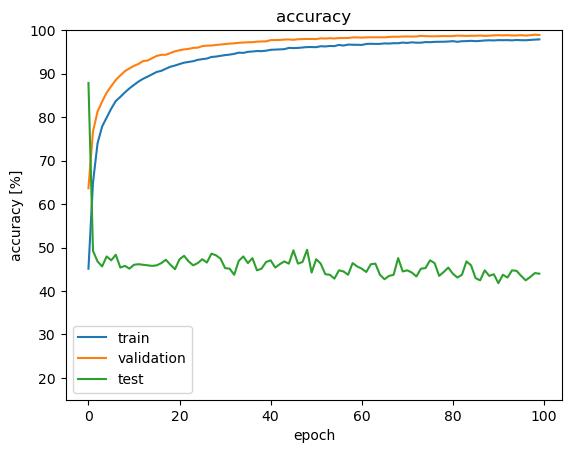

In [5]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_accuracy, label="train")
plt.plot(x, val_accuracy, label="validation")
plt.plot(x, test_accuracy, label="test")

# グラフのタイトルと軸ラベルの作成
plt.ylim(15, 100)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.legend()
plt.savefig("../images/accuracy.jpg")

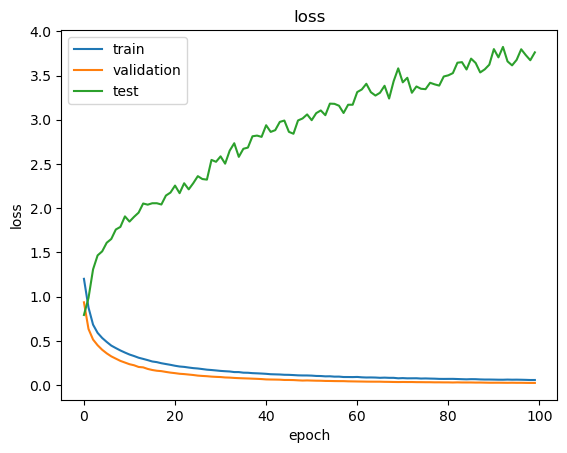

In [6]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_error, label="train")
plt.plot(x, val_error, label="validation")
plt.plot(x, test_error, label="test")

# グラフのタイトルと軸ラベルの作成
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("../images/loss.jpg")

# 推定

loss : 0.00181, acc : 0.43990, recall : 0.43990, precision : 0.43990, f1_score : 0.43990
tensor([[  4.,   0.,  10., 193.],
        [  0., 157.,   2.,   0.],
        [ 56.,  21.,  93.,   0.],
        [ 54.,   0., 102.,  90.]])


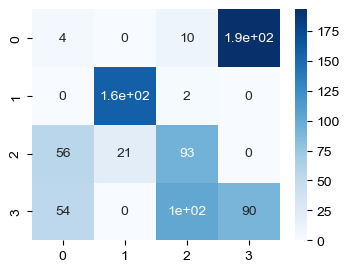

In [7]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics import MulticlassConfusionMatrix

accuracy = MulticlassAccuracy(
        average = "micro",
        num_classes = 4
)
recall = MulticlassRecall(
        average = "micro",
        num_classes = 4
)
precision = MulticlassPrecision(
        average = "micro",
        num_classes = 4
)
f1_score = MulticlassF1Score(
        average = "micro",
        num_classes = 4 
)
confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)
loss = 0
n = 0

for input, label in test_loader:
        n += len(test_label)

        input = input.to(device)
        label = label.to(device)

        output = net(input)
        test_loss = criterion(output, label)

        predicted = torch.max(output, 1)[1]

        loss += test_loss.item()
        accuracy.update(predicted, label)
        recall.update(predicted, label)
        precision.update(predicted, label)
        f1_score.update(predicted, label)
        confusion_mat.update(predicted, label)
        
# 精度を確率に変換
acc = accuracy.compute().item()
recall = recall.compute().item()
precision = precision.compute().item()
f1_score = f1_score.compute().item()
confusion_mat = confusion_mat.compute()
test_loss = test_loss * batch_size / n_test

print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}, recall : {recall:.5f}, precision : {precision:.5f}, f1_score : {f1_score:.5f}")
print(confusion_mat)

import utills.record_utillities as ru
confusion_mat = confusion_mat.to('cpu').detach().numpy().copy()
ru.save_confusion_matrix(confusion_mat)